<h1>License Plate Number Extraction. (Untrained)</h1>
<span>

Optimized for Indian license plates.
<br>V 1.0.0
<br>Date [Tue 6 Jun 2023]
<br>Author [Raghav Singh]
</span>

In [1]:
# Importing modules required for the project
import cv2
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, MaxPool2D
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras import backend as K
import np_utils

from sklearn.model_selection import train_test_split

In [2]:
img_input = cv2.imread('/Users/raghavsingh/Documents/Projects/numberplate1.jpeg')
# img_input = cv2.imread('/Users/raghavsingh/Documents/Projects/numberplate.webp')

<h3>What are Haarcascades?</h3>
<p>
Haarcascades is an algorithm that is used to detect certain objects in images. 
In our case that object is a license plate.

First we will load our cascading model and then apply it to the image.
Here scaleFactor is a number that helps scale the image for better detection
minNeighbours is used to reduce false positives (if this is low it can decrease accuracy)
</p>

In [3]:
# Loading our cascading model
haarcascade_path = '/Users/raghavsingh/Documents/Projects/haarcascade_indian_license_plate.xml'
haarcascade = cv2.CascadeClassifier(haarcascade_path)

# Identify the license plate contour + Return Coordinates && Dimensions of contours 
plate_contour = haarcascade.detectMultiScale(img_input, 1.3, 7)

img_copy = img_input.copy()

for (x,y,w,h) in plate_contour:
	# parameter tuning constants
	a,b = (int(0.01*img_input.shape[0]), int(0.0125*img_input.shape[1])) 
	# Cropping image : Defining a numpy array with pixel y+a to y+h and x+b to x+w
	plate_cropped_img = img_copy[y+a:y+h-a, x+b:x+w-b]
	# finally representing the detected contours by drawing rectangles around the edges.
	cv2.rectangle(img_copy, (x,y), (x+w, y+h), (51,51,255), 3)


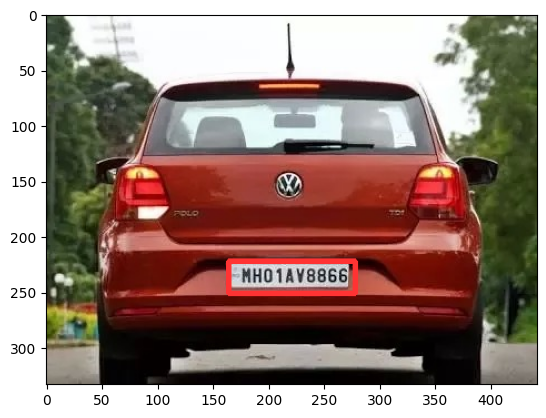

In [4]:
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))

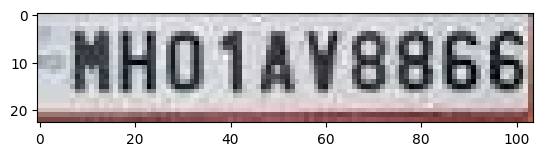

In [5]:
plt.imshow(cv2.cvtColor(plate_cropped_img, cv2.COLOR_BGR2RGB))

<h3>Image PreProcessing</h3>

<span>
In this process we will:
<ul>

<li>
Convert color function = Convert the image from 3 channel BGR to 1 channel 8-bit format, where range[0,255] || [black,white]
</li>

<li>
Threshold function = The greyscale image is now coverted to binary format where 0 is black and 1 is white. It is done by applying a threshold at 200 between values 0 and 255. 
    <ul>
        <li>if the value pixel is < 200 then the pixel is black</li>
        <li>elif the value of pixel is > 200 then the pixel is white</li>
    </ul>
</li>

<li> Eroding : Here we remove unwanted pixels from the image's edges. It considers the pixel and all neighbours to give a result.
    <ul>
        <li>The text font is black and the bgColor is white.</li>
        <li>Any noise on the edges will be black or 0.</li>
        <li>It considers each pixel one by one.</li>
        <li>What we are addressing - Pixel which should have value 1 but have value 0. (Smoothing edges)</li>
    </ul>
</li>

<li> 
    Dilation : Here we remove any absent pixels from the image. It considers the pixel and only 1 neighbour to give a result.
    <ul>
        <li>It works similar to eroding.</li>
    </ul>
</li>

<li> 
    Make borders white to remove any out of frame pixels.
</li>

<li> 
    Define a list of dimensions that contains 4 values.
    <ul>
        <li>We will use these values to compare with a character’s dimensions.</li>
        <li>That will help us find the right character.</li>
    </ul>
</li>
</ul>
The image is ready for character extraction.
</span>

In [6]:
plate_cropped_img = cv2.resize(plate_cropped_img, (333, 75))
img_gray = cv2.cvtColor(plate_cropped_img, cv2.COLOR_BGR2GRAY)
_, img_bin = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
img_erode = cv2.erode(img_bin,(3,3))
img_dilate = cv2.dilate(img_erode,(3,3))

LP_WIDTH = img_dilate.shape[0]
LP_HEIGHT = img_dilate.shape[1]

img_dilate[0:3,:] = 255
img_dilate[:,0:3] = 255
img_dilate[72:75,:] = 255
img_dilate[:,330:333] = 255

dimensions = [LP_WIDTH/6, LP_WIDTH/2, LP_HEIGHT/10, 2*LP_HEIGHT/3]

# Get contours within cropped license plate

<h3>What is Contour?</h3>
<span>
    A contour is a curve of a particular color and intensity which joins all continuous points with the same boundary.

<br><br>
Explaination of the lambda function:
<ul>
    <li>
        Given the code snippet indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k]), and considering 
    </li>    
    <li>
        x_cntr_list = [5, 2, 8, 1], here's how the list [3, 1, 0, 2] is obtained:
    </li>
</ul>

The range(len(x_cntr_list)) generates an iterable range of indices from 0 to the length of x_cntr_list minus 1. In this case, it produces the range [0, 1, 2, 3].
<br>    
    The sorted() function is used to sort the indices based on the values returned by the key function, which is the lambda function lambda k: x_cntr_list[k]. This lambda function takes an index k and returns the corresponding value from x_cntr_list at index k.
<ul>    
    <li>
        When we apply the lambda function to each index in the range [0, 1, 2, 3], we get the following values:
    </li>
    <li>
        For index 0: x_cntr_list[0] = 5
    </li>
    <li>
        For index 1: x_cntr_list[1] = 2
    </li>
    <li>
        For index 2: x_cntr_list[2] = 8
    </li>
    <li>
        For index 3: x_cntr_list[3] = 1
    </li>
</ul>

The sorted() function sorts the indices [0, 1, 2, 3] based on the corresponding values [5, 2, 8, 1] returned by the lambda function. The sorted indices are [3, 1, 0, 2].

Therefore, the resulting indices list is [3, 1, 0, 2]. It represents the indices in ascending order, corresponding to the sorted values in x_cntr_list: [1, 2, 5, 8].
</span>

In [7]:
# Finding contours in a copy of the pre-processed image
contours, _ = cv2.findContours(img_dilate.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Finding dimensions
lower_width = dimensions[0]
upper_width = dimensions[1]
lower_height = dimensions[2]
upper_height = dimensions[3]

# Sorting the largest contours 15 contours in desc order
contours = sorted(contours, key = cv2.contourArea, reverse=True )[:15]

x_contour_list = []
# List that stores character's bin img
bin_img = []

for contour in contours:
    # Find coordinates of the bounding rectangle around contour
    c_X, c_Y, c_width, c_height = cv2.boundingRect(contour)

    if lower_width < c_width and c_width < upper_width and lower_height < c_height and c_height < upper_height:
        # Storing the x coordinate of the contour for sorting later
        x_contour_list.append(c_X)

        # Making a numpy array of 44 rows and 24 columns
        char_temp = np.zeros((44,24))
        # Extracting the character by using the bounding rectangle coordinates of the contour
        char = img_dilate[c_Y:c_Y+c_height,c_X:c_X+c_width]
        # Resizing the character image
        char = cv2.resize(char,(20,40))
        # Invert Colors
        char = cv2.subtract(255,char)

        # Generating temp character(44,24) with black borders and character
        char_temp[2:42,2:22] = char 
        # black borders
        char_temp[0:2,:]= 0
        char_temp[:,0:2]= 0
        char_temp[42:44,:]= 0
        char_temp[:,22:24]= 0

        # Adding the bin image in list *The characters may be unsorted here
        bin_img.append(char_temp)

# Returning the characters in asc order wrt the x coordinates stored in x_contour_list
indices = sorted(range(len(x_contour_list)), key = lambda k : x_contour_list[k])
# Using sorted indices to sort bin_img list
bin_img_copy = []
for index in indices:
    bin_img_copy.append(bin_img[index])
bin_img = np.array(bin_img_copy)


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from keras.optimizers.legacy import Adam

In [9]:
model = Sequential()
model.add(Conv2D(32, (24,24), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

optimizer = Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
batch_size = 1
# callbacks = [tensorboard_callback, stop_training_callback()]
data_train_path = '/Users/raghavsingh/Documents/Projects/data/train'
data_val_path = '/Users/raghavsingh/Documents/Projects/data/val'

# The size of image in the dataset is 28 x 28
train_generator = train_datagen.flow_from_directory( data_train_path,  
                                                    target_size=(28,28),  
                                                    batch_size=1, 
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory( data_val_path, 
                                                         target_size=(28,28), 
                                                         batch_size=1, 
                                                         class_mode='categorical') 

# Define the desired accuracy threshold
# desired_accuracy = 0.99

# Define early stopping callback with accuracy threshold
# early_stopping = EarlyStopping(monitor='accuracy', min_delta=0, patience=0, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
from tensorflow import keras

# Define the callback
class AccuracyCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.99:
            self.model.stop_training = True
# Create an instance of the callback
callback = AccuracyCallback()

model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples//batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples//batch_size,
      epochs = 100, callbacks=[callback])

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
Epoch 1/100
 32/864 [>.............................] - ETA: 4s - loss: 0.0056 - accuracy: 1.0000

2023-06-09 23:28:35.884368: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


862/864 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9838

2023-06-09 23:28:40.452855: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


864/864 [==============================] - 5s 6ms/step - loss: 0.0380 - accuracy: 0.9838 - val_loss: 0.0347 - val_accuracy: 0.9954
Epoch 2/100
864/864 [==============================] - 5s 6ms/step - loss: 0.0453 - accuracy: 0.9826 - val_loss: 0.0369 - val_accuracy: 0.9861
Epoch 3/100
864/864 [==============================] - 5s 6ms/step - loss: 0.0453 - accuracy: 0.9850 - val_loss: 0.0422 - val_accuracy: 0.9861
Epoch 4/100
864/864 [==============================] - 5s 5ms/step - loss: 0.0507 - accuracy: 0.9803 - val_loss: 0.0456 - val_accuracy: 0.9769
Epoch 5/100
864/864 [==============================] - 5s 5ms/step - loss: 0.0340 - accuracy: 0.9873 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 6/100
864/864 [==============================] - 5s 5ms/step - loss: 0.0432 - accuracy: 0.9815 - val_loss: 0.0365 - val_accuracy: 0.9907
Epoch 7/100
864/864 [==============================] - 5s 5ms/step - loss: 0.0433 - accuracy: 0.9780 - val_loss: 0.0412 - val_accuracy: 0.9769
Epoch 8/100

In [ ]:
# model.save('trained_model.h5')

In [ ]:
from keras.models import load_model
model = load_model('trained_model.h5')

def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
dic = {}
characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
for i,c in enumerate(characters):
    dic[i] = c

output = []
plate_number = ''
for i,ch in enumerate(bin_img): #iterating over the characters
    img_ = cv2.resize(ch, (28,28))
    img = fix_dimension(img_)
    img = img.reshape(1,28,28,3) #preparing image for the model
    y_ = model.predict(img)[0] #predicting the class
    # print(y_)
    index = np.where(y_ == 1)[0]
    int_index = int(index[0])
    # print(int_index)
    plate_number += dic[int_index]
print(plate_number)

1/1 [==============================] - 0s 9ms/step
MH01AY8866
